In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from math import sqrt
import math
import scipy
import scipy.ndimage
from skimage.morphology import skeletonize as skelt
from skimage.morphology import thin
# from google.colab.patches import cv2_imshow

#### Only 2000 images out of the 4000 images available in the NIST-4 database were used due to system constraints. These results wont be as accurate as the results mentioned in the research papers due to less data being used

# Pre-Processing step functions

### Normalisation

In [2]:
def normalize_pixel(x, v0, v, m, m0):
    """
    From Handbook of Fingerprint Recognition pg 133
    Normalize job used by Hong, Wan and Jain(1998)
    similar to https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf equation 21
    :param x: pixel value
    :param v0: desired variance
    :param v: global image variance
    :param m: global image mean
    :param m0: desired mean
    :return: normilized pixel
    """
    dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
    return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

### Segmentation

In [3]:
def normalise(img):
    return (img - np.mean(img))/(np.std(img))


def create_segmented_and_variance_images(im, w, threshold=.2):
    """
    Returns mask identifying the ROI. Calculates the standard deviation in each image block and threshold the ROI
    It also normalises the intesity values of
    the image so that the ridge regions have zero mean, unit standard
    deviation.
    :param im: Image
    :param w: size of the block
    :param threshold: std threshold
    :return: segmented_image
    """
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # normalize segmented image
    segmented_image *= mask
    im = normalise(im)
    mean_val = np.mean(im[mask==0])
    std_val = np.std(im[mask==0])
    norm_img = (im - mean_val)/(std_val)

    return segmented_image, norm_img, mask

### Orientation Map

In [4]:
def calculate_angles(im, W, smoth=False):
    """
    anisotropy orientation estimate, based on equations 5 from:
    https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf
    :param im:
    :param W: int width of the ridge
    :return: array
    """
    j1 = lambda x, y: 2 * x * y
    j2 = lambda x, y: x ** 2 - y ** 2
    j3 = lambda x, y: x ** 2 + y ** 2

    (y, x) = im.shape

    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobelOperator).astype(np.int)
    xSobel = np.transpose(ySobel).astype(np.int)

    result = [[] for i in range(1, y, W)]

    Gx_ = cv.filter2D(im/125,-1, ySobel)*125
    Gy_ = cv.filter2D(im/125,-1, xSobel)*125

    for j in range(1, y, W):
        for i in range(1, x, W):
            nominator = 0
            denominator = 0
            for l in range(j, min(j + W, y - 1)):
                for k in range(i, min(i + W , x - 1)):
                    Gx = round(Gx_[l, k])  # horizontal gradients at l, k
                    Gy = round(Gy_[l, k])  # vertial gradients at l, k
                    nominator += j1(Gx, Gy)
                    denominator += j2(Gx, Gy)

            # nominator = round(np.sum(Gy_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            # denominator = round(np.sum(Gx_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            if nominator or denominator:
                angle = (math.pi + math.atan2(nominator, denominator)) / 2
                orientation = np.pi/2 + math.atan2(nominator,denominator)/2
                result[int((j-1) // W)].append(angle)
            else:
                result[int((j-1) // W)].append(0)

            # segment image
            # focus_img = im[j:min(j + W, y - 1), i:min(i + W , x - 1)]
            # segmentator = -1 if segmentator/W*W < np.max(focus_img)*

    result = np.array(result)

    if smoth:
        result = smooth_angles(result)

    return result


def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))


def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel


def smooth_angles(angles):
    """
    reference: https://airccj.org/CSCP/vol7/csit76809.pdf pg91
    Practically, it is possible to have a block so noisy that the directional estimate is completely false.
    This then causes a very large angular variation between two adjacent blocks. However, a
    fingerprint has some directional continuity, such a variation between two adjacent blocks is then
    representative of a bad estimate. To eliminate such discontinuities, a low-pass filter is applied to
    the directional board.
    :param angles:
    :return:
    """
    angles = np.array(angles)
    cos_angles = np.cos(angles.copy()*2)
    sin_angles = np.sin(angles.copy()*2)

    kernel = np.array(kernel_from_function(5, gauss))

    cos_angles = cv.filter2D(cos_angles/125,-1, kernel)*125
    sin_angles = cv.filter2D(sin_angles/125,-1, kernel)*125
    smooth_angles = np.arctan2(sin_angles, cos_angles)/2

    return smooth_angles


def get_line_ends(i, j, W, tang):
    if -1 <= tang and tang <= 1:
        begin = (i, int((-W/2) * tang + j + W/2))
        end = (i + W, int((W/2) * tang + j + W/2))
    else:
        begin = (int(i + W/2 + W/(2 * tang)), j + W//2)
        end = (int(i + W/2 - W/(2 * tang)), j - W//2)
    return (begin, end)


def visualize_angles(im, mask, angles, W):
    (y, x) = im.shape
    result = cv.cvtColor(np.zeros(im.shape, np.uint8), cv.COLOR_GRAY2RGB)
    mask_threshold = (W-1)**2
    for i in range(1, x, W):
        for j in range(1, y, W):
            radian = np.sum(mask[j - 1:j + W, i-1:i+W])
            if radian > mask_threshold:
                tang = math.tan(angles[(j - 1) // W][(i - 1) // W])
                (begin, end) = get_line_ends(i, j, W, tang)
                cv.line(result, begin, end, color=150)

    cv.resize(result, im.shape, result)
    return result

---

### Importing Data

In [5]:
image_files = glob.glob1('D:/college/Research/NIST/Biometrics-Project-main/png_txt/half_data', '*.png')

X_cnn_im,y_cnn_im = [], []
dir = 'D:/college/Research/NIST/Biometrics-Project-main/png_txt/half_data/'
for image in sorted(image_files):

  X_cnn_im.append(plt.imread(dir+image))
  y_cnn_im.append(str(image[0]))

### Pre-Processing Pipeline

In [6]:
X_orient = []
for input_img in X_cnn_im:
  normalized_img = normalize(input_img.copy(), float(100), float(100))

  # ROI and normalisation
  (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

  # orientations
  angles = calculate_angles(normalized_img, W=16, smoth=False)
  orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

  X_orient.append(orientation_img)

# X_orient contains the Orientation maps of the fingerprints which will help our computations immensely

C:\Users\91704\AppData\Local\Temp\ipykernel_19364\1413609433.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ySobel = np.array(sobelOperator).astype(np.int)
C:\Users\91704\AppData\Local\Temp\ipykernel_19364\1413609433.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

In [7]:
# label encoding the classes
y_cnn = np.array(y_cnn_im)
import sklearn
from sklearn.preprocessing import LabelEncoder
encde=LabelEncoder()
y_encode=encde.fit_transform(y_cnn)

---

# KNN Model

In [27]:
# flatenning the image for knn
X_knn = []
for orient in X_orient:
    X_knn.append(np.array(orient).flatten())
X_knn = np.array(X_knn)

### Splitting the data

In [29]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_cnn, test_size=0.25, random_state=42)

### Building and training the model

In [30]:
k_range = list(range(1,21))

param_grid={'n_neighbors' : k_range}
knn = KNeighborsClassifier()
model_knn = GridSearchCV(knn, param_grid, cv=10)

In [31]:
model_knn.fit(X_train_knn,y_train_knn)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]})

In [32]:
print('Best value of k is: ', model_knn.best_params_)

Best value of k is:  {'n_neighbors': 15}


### Accuracy

In [33]:
y_pred_knn = model_knn.predict(X_test_knn)
print(accuracy_score(y_pred_knn,y_test_knn))

0.372


--- 

# LeNet-5 Architecture

In [34]:
X_lenet = np.array(X_orient)

### Splitting the data

In [43]:
X_train_lenet, X_test_lenet, y_train_lenet, y_test_lenet = train_test_split(X_lenet, y_encode, test_size=0.25, random_state=42)

### Building the LeNet-5 architecture and training the model

In [39]:
model_lenet = keras.Sequential()

model_lenet.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(512,512,3)))
model_lenet.add(layers.AveragePooling2D())

model_lenet.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_lenet.add(layers.AveragePooling2D())

model_lenet.add(layers.Flatten())

model_lenet.add(layers.Dense(units=120, activation='relu'))

model_lenet.add(layers.Dense(units=84, activation='relu'))

model_lenet.add(layers.Dense(units=5, activation = 'softmax'))

model_lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 510, 510, 6)       168       
                                                                 
 average_pooling2d_2 (Averag  (None, 255, 255, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 253, 253, 16)      880       
                                                                 
 average_pooling2d_3 (Averag  (None, 126, 126, 16)     0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [40]:
model_lenet.compile(loss=keras.metrics.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [45]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
    history_lenet = model_lenet.fit(X_train_lenet, y_train_lenet, batch_size=32, epochs=30, validation_split=0.15, verbose=1)

Epoch 1/30
20/20 [==============================] - 10s 271ms/step - loss: 4.1415 - accuracy: 0.6374 - val_loss: 4.5948 - val_accuracy: 0.4867
Epoch 2/30
20/20 [==============================] - 4s 182ms/step - loss: 0.8158 - accuracy: 0.8257 - val_loss: 2.5338 - val_accuracy: 0.5133
Epoch 3/30
20/20 [==============================] - 4s 182ms/step - loss: 0.1950 - accuracy: 0.9372 - val_loss: 2.2071 - val_accuracy: 0.5929
Epoch 4/30
20/20 [==============================] - 4s 181ms/step - loss: 0.0627 - accuracy: 0.9796 - val_loss: 2.1849 - val_accuracy: 0.5929
Epoch 5/30
20/20 [==============================] - 4s 181ms/step - loss: 0.0126 - accuracy: 0.9984 - val_loss: 1.9945 - val_accuracy: 0.5929
Epoch 6/30
20/20 [==============================] - 4s 183ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.9740 - val_accuracy: 0.6283
Epoch 7/30
20/20 [==============================] - 4s 182ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.9585 - val_accuracy: 0.6195
Epoch

In [47]:
print('test loss, test accuracy: ', model_lenet.evaluate(X_test_lenet, y_test_lenet))

8/8 [==============================] - 1s 85ms/step - loss: 1.7627 - accuracy: 0.6520
test loss, test accuracy:  [1.762732982635498, 0.6520000100135803]


### LeNet-5 Training Visualisation

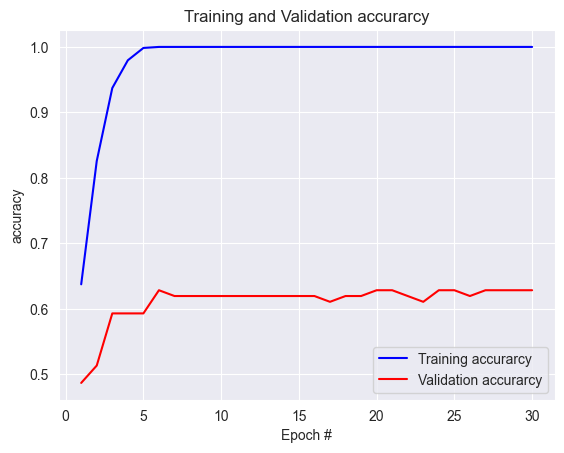

In [48]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_lenet.history['accuracy']
val_acc = history_lenet.history['val_accuracy']
loss = history_lenet.history['loss']
val_loss = history_lenet.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

---

# AlexNet Architecture

In [8]:
# resizing the images for AlexNet
X_alex = []
for image in X_orient:
    X_alex.append(cv.resize(image, (227,227)))

# converting to numpy array
X_alex = np.array(X_alex)

In [9]:
X_alex.shape

(1000, 227, 227, 3)

### Splitting the data

In [10]:
X_train_alex, X_test_alex, y_train_alex, y_test_alex = train_test_split(X_alex, y_encode, test_size=0.25, random_state=42)

### Building the AlexNet architecture and training the model

In [11]:
model_alexnet = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])

model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [12]:
model_alexnet.compile(loss=keras.metrics.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [16]:
with tf.device('/GPU:0'):
    history_alexnet = model_alexnet.fit(X_train_alex, y_train_alex, batch_size=32, epochs=150, validation_split=0.15, verbose=1)

Epoch 1/150
20/20 [==============================] - 2s 90ms/step - loss: 0.1208 - accuracy: 0.9733 - val_loss: 4.6237 - val_accuracy: 0.6106
Epoch 2/150
20/20 [==============================] - 2s 89ms/step - loss: 0.3658 - accuracy: 0.9372 - val_loss: 7.9676 - val_accuracy: 0.5487
Epoch 3/150
20/20 [==============================] - 2s 89ms/step - loss: 0.2873 - accuracy: 0.9435 - val_loss: 3.3441 - val_accuracy: 0.5929
Epoch 4/150
20/20 [==============================] - 2s 87ms/step - loss: 0.0656 - accuracy: 0.9780 - val_loss: 3.3182 - val_accuracy: 0.6814
Epoch 5/150
20/20 [==============================] - 2s 89ms/step - loss: 0.1053 - accuracy: 0.9843 - val_loss: 3.0726 - val_accuracy: 0.6637
Epoch 6/150
20/20 [==============================] - 2s 89ms/step - loss: 0.0285 - accuracy: 0.9922 - val_loss: 3.0181 - val_accuracy: 0.7168
Epoch 7/150
20/20 [==============================] - 2s 88ms/step - loss: 0.0855 - accuracy: 0.9890 - val_loss: 3.7071 - val_accuracy: 0.6283
Epoch 

Epoch 115/150
20/20 [==============================] - 2s 88ms/step - loss: 0.2238 - accuracy: 0.9796 - val_loss: 20.8901 - val_accuracy: 0.5575
Epoch 116/150
20/20 [==============================] - 2s 87ms/step - loss: 0.1194 - accuracy: 0.9937 - val_loss: 17.8421 - val_accuracy: 0.6372
Epoch 117/150
20/20 [==============================] - 2s 88ms/step - loss: 0.0550 - accuracy: 0.9922 - val_loss: 17.6963 - val_accuracy: 0.5929
Epoch 118/150
20/20 [==============================] - 2s 87ms/step - loss: 0.3249 - accuracy: 0.9906 - val_loss: 24.8756 - val_accuracy: 0.6372
Epoch 119/150
20/20 [==============================] - 2s 87ms/step - loss: 0.8392 - accuracy: 0.9623 - val_loss: 27.3287 - val_accuracy: 0.6106
Epoch 120/150
20/20 [==============================] - 2s 88ms/step - loss: 0.8695 - accuracy: 0.9796 - val_loss: 21.9090 - val_accuracy: 0.5929
Epoch 121/150
20/20 [==============================] - 2s 88ms/step - loss: 0.8341 - accuracy: 0.9670 - val_loss: 21.4799 - val_ac

In [14]:
print('test loss, test accuracy: ', model_alexnet.evaluate(X_test_alex, y_test_alex))

8/8 [==============================] - 1s 168ms/step - loss: 6.7492 - accuracy: 0.4680
test loss, test accuracy:  [6.749238014221191, 0.46799999475479126]


### AlexNet Training Visualisation

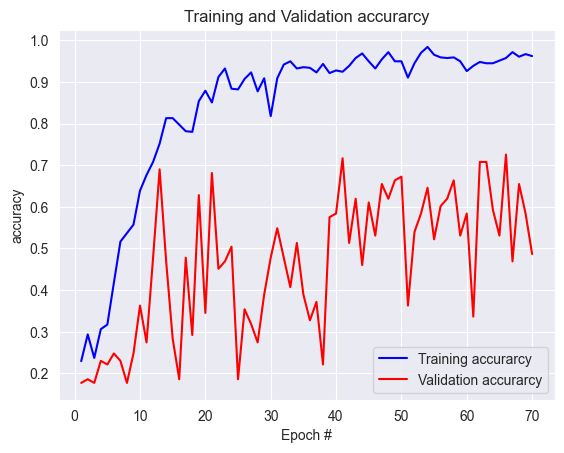

In [15]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']
loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

--- 

## Results:

### - KNN: Accuracy = 37.2% (Best K value=15)
### - LeNet 5: Accuracy = 65.2%; Loss = 1.76
### - AlexNet: Accuracy = 46.8%; Loss = 6.74

### It is clearly evident that performing feature extraction and feeding Orientation maps of the fingerprints has increase the accuracy of all the models.
### KNN is an ML classifier so it would not perform well with images and we can see that by looking at the accuracy.
### Both the convolutional networks overfit, an issue which could be resolved by feeding in more data*.
### AlexNet and LeNet-5 are fairly older architectures and do not perform well with the fingerprint database as it was shown in [Fingerprint pattern identification and classification approach based on convolutional neural networks](https://link.springer.com/article/10.1007/s00521-019-04499-w)
### We will try to improve our classifier by using more robust and complex pre-trained CNN architectures.

---